# [krx]데이터 자동 수집을 위한 가이드
이번에는 주식 데이터를 자동 수집을 해보자. 이번은 간단하게 crontab를 사용해 매일 17시에 실행을 하여 주식 데이터를 수집 할 것이다. 지금은 한가지 주식을 해보지만 다음에는 여러가지의 주식 정보를 수집하는 방법을 블로깅 해보겠다.<br>목차는 다음과 같다.
- 주피터 파일 생성 후 데이터 수집 코드 생성
- 주피터 파일 파이썬 파일로 변경
- crontab을 이용해 월~금 5시 주식 데이터 수집 

# 1. 코드 작성

## 1-1 라이브러리 불러오기

In [2]:
import pandas as pd
import datetime
import sqlite3 
from pykrx import stock

## 1-2 datetime 불러오기

In [3]:
today = datetime.datetime.now()
today

datetime.datetime(2021, 12, 10, 4, 33, 51, 579993)

In [4]:
#datetime_df = pd.DataFrame({'year':[today.year],
                          # 'month':[today.month],
                          # 'day':[today.day],
                          # 'hour':[today.hour],
                          # 'minute':[today.minute]})

In [5]:
#datetime_df

## 1-3 yesterday 데이터 추가

In [6]:
yesterday = today - datetime.timedelta(days=1)

In [7]:
yesterday

datetime.datetime(2021, 12, 9, 4, 33, 51, 579993)

## 1-4 필요한 년,월,일 데이터 만들기

In [8]:
yesterday = str(yesterday.year) + str(yesterday.month) + str(yesterday.day)
today = str(today.year) + str(today.month) + str(today.day)

In [9]:
yesterday

'2021129'

In [10]:
today

'20211210'

## 1-6 주식 데이터 불러오기
get_market_ohlcv_by_date() 메서드를 사용해 데이터를 데이터 프레임 형태로 다운

In [11]:
df = stock.get_market_ohlcv_by_date(fromdate=yesterday, todate=today, ticker="005930")
df

,시가,고가,저가,종가,거래량
날짜,,,,,
2021-12-10,77400,77600,76800,76900,6252688


## 1-7 날짜 인덱스 컬럼으로 수정

In [12]:
df = df.reset_index()
df

,날짜,시가,고가,저가,종가,거래량
0,2021-12-10,77400,77600,76800,76900,6252688


## 1-8 날짜 컬럼 추가
sqlite3는 datetime 타입을 지원하지 않아 int 타입으로 수정하기위해 나누었다.

In [13]:
df["year"] = df["날짜"].dt.year
df["month"] = df["날짜"].dt.month
df["day"] = df["날짜"].dt.day
df.shape

(1, 9)

In [14]:
df

,날짜,시가,고가,저가,종가,거래량,year,month,day
0,2021-12-10,77400,77600,76800,76900,6252688,2021,12,10


## 1-9 날짜 컬럼 삭제
날짜 컬럼 삭제 inplace=True 명령어를 넣어주어야 데이터 프레임에 적용된다.

In [15]:
df.drop(["날짜"], axis=1, inplace=True)

In [16]:
df

,시가,고가,저가,종가,거래량,year,month,day
0,77400,77600,76800,76900,6252688,2021,12,10


# 2.SQlite3활용 db로 저장

## 2-1 DB 호출
- crontab_db_stock가 없을 경우 새로 생성하며 연결
- crontab_db_stock가 있을경우 해당 db로 연걸

In [17]:
conn = sqlite3.connect("crontab_db_stock.db")

## 2-2.cursor 생성
- conn.cursor을 통해 Cursor를 하나 생성

In [18]:
cur = conn.cursor()

## 2-3.conn.execute를 통해 stock_data 테이블을 생성합니다.

In [19]:
conn.execute('CREATE TABLE IF NOT EXISTS stock_data(open int, High int,Low int, Closing int, Volumn int, year int,month int, day int)')

## 2-4.data int 변경

dataframe에서 데이터 선택수 int로 변경 (SQL 테이블 생성시 자료형을 INT 로 했기 때문)

In [20]:
open_value = int(df['시가'])
High_value = int(df['고가'])
Low_value = int(df['저가'])
Closing_value = int(df['종가'])
Volumn_value = int(df['거래량'])
year_value = int(df['year'])
month_value = int(df['month'])
day_value = int(df['day'])

## 2-5.데이터 삽입 (insert)

생성해둔 데이터 프레임 datetime_df에서 각각의 데이터를 삽입

In [21]:
cur.execute('INSERT INTO stock_data VALUES(:open, :High, :Low, :Closing, :Volumn, :year, :month, :day);',
           {"open":open_value,"High":High_value,"Low":Low_value,"Closing":Closing_value,"Volumn":Volumn_value,"year":year_value,
            "month":month_value,"day":day_value})

## 2-6 pandas사용하여 데이터 프레임 호출

In [22]:
# cur.execute를 이용해 SELECT 쿼리를 실행한다
cur.execute("SELECT * FROM stock_data")

# 행 데이터를 가져오기
rows = cur.fetchall()

# columns열 이름을 가져오기
cols = [column[0] for column in cur.description]

# 코드를 활요하여 DataFrame을 만들어주기
data_df = pd.DataFrame.from_records(data=rows, columns=cols)

In [23]:
data_df

,open,High,Low,Closing,Volumn,year,month,day
0,77400,77600,76800,76900,6252688,2021,12,10


## 2-7.변경사항 저장 (commit)

In [24]:
conn.commit()

## 2-7.DB 종료

In [25]:
conn.close()

# 3.크론탭 사용

## 3-1.주피터 파일 파이썬으로 변경

$ jupyter nbconvert --to script [파일명].ipynb 

자 이렇게 파이썬 파일로 변경 후 크론탭으로 주기 설정 및 코드 입력을 해보도록 하자.

## 3-2 리눅스 명령어 설정
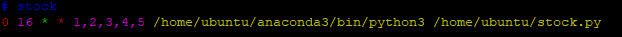
- corntab - e 코드로 크론탭 설정창 이동 후 제일 밑으로 내려가 명령어 입력!
- 설정창 입력 방법은 a를 눌러 INSERT 모드 변경 후 입력
- 저장 후 나가는 방법은 Esc -> : -> wq(저장하고 나가기) -> Enter 나가기!
- 주기 설정 월요일~금요일 17시 마다 실행

# 4. DB 확인
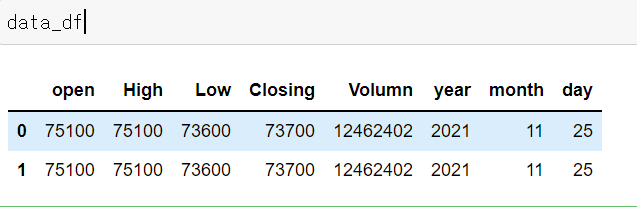

내일 17시에 잘 실행되기를 기도하며!!!!! 마무리!!!!

이렇게 마무리를 하고 이번에 sqlte3를 이용하여 DB에 자동으로 적재하는 법을 해보았다. 지금은 한가지 주식 정보를 적재하지만 다음에는 더 많은 정보를 적재해보자. 